#  Textual Content Moderation using Cognitive Services and Python

**NOTE:** This notebook will not run properly on the Microsoft Azure Notebooks platform because their virtual machines use an older version of OpenSSL that is not comaptible with Microsoft's Azure Cognitive Services APIs. ***You will therefore need to run this notebook in Google Colab***.

In this lab assignment, we will be using one of the **Microsoft Azure Cognitive Services** to build a system that can automatically detect inappropriate content such as profanity, hate speech, threats, racism, etc. in written text. Recall that **cognitive computing** involves using artificial intelligence technologies to build systems that can perform tasks which could previously only be accomplished by the human mind. The detection of inappropriate content in written text is an excellent example of such a task, and as such we will building a **cognitive computing system** in this lab assignment.

By the time you have completed this lab, you will have achieved all of the following learning objectives:

## Learning Objectives

* Understand what Azure Cognitive Services are.
* Have the ability to configure and provision cognitive services as resources on the Microsoft Azure platform.
* Understand the purpose of an application programming interface (API).
* Use Python to connect to and interact with the Content Moderator cognitive service via its API.
* Have the ability to iteratively send written comments to the Content Moderator cognitive service, and process the results to determine if the written comments are inappropriate or obscene.
* Analyze the results obtained from the Content Moderator cognitive service, and compare the performance of those results to labels assigned by human judges.
* Continue to develop skills working with and analyzing data in Python.

## About Azure Cognitive Services

According to Microsoft:

> "Cognitive Services bring AI within reach of every developer... All it takes is an API call to embed the ability to see, hear, speak, search, understand, and accelerate decision-making into your apps."

Microsoft currently has **nearly 30 cognitive service APIs** available that can perform a wide variety of tasks. We will be using several of these APIs in our remaining lab assignments, and you will also need to use at least one of these APIs in your final project.

You may learn more about Azure Cognitive Services [on this website](https://azure.microsoft.com/en-us/services/cognitive-services).

## About the Content Moderator Cognitive Service

According to Microsoft:

> "Azure Content Moderator is a cognitive service that checks text, image, and video content for material that is potentially offensive, risky, or otherwise undesirable. When this material is found, the service applies appropriate labels (flags) to the content. Your app can then handle flagged content in order to comply with regulations or maintain the intended environment for users."

The Content Moderator service is hence intended to provide developers with an all-in-one solution to content moderation tasks. If you consider the Web in its entirety, you will notice that a great deal of content is **user generated**. For example, virtually all of the content on websites such as Twitter, Facebook, Instagram, YouTube, Stack Overflow, Wikipedia, etc. is created by users, and not by the companies that operate those websites. In order to provide a positive experience for as many users as possible, companies are highly interested in ensuring that potentially offensive content is not contained in the videos, images, or written text that users post on the companies' websites. The purpose of the Content Moderator service, then, is to provide a single API that can be used to detect inappropriate content in text, images, or video. We will be using only the text moderation part of the API in this lab assignment, but I wanted you to be aware of the API's image and video moderation services, as well.

You may learn more about the Content Moderator service [on this website](https://azure.microsoft.com/en-us/services/cognitive-services/content-moderator).

## About APIs

An API (Application Programming Interface) is an interface that allows the resources, capabilities, or services of one computer system to be used by other computer systems. As with functions in computer programs, using an API typically involves passing one or more inputs to the system that provides the API, which then returns one or more outputs back to the system that called the API.

To learn more about APIs, please read [this article](https://en.wikipedia.org/wiki/Application_programming_interface).

## Lab Prerequisites

To complete this, you will need to complete the following tasks:

*   Create or sign into a Microsoft Azure account. If you do not already have an Azure account, then please sign up for a free student account [on this website](https://azure.microsoft.com/en-us/free/students).
*   Add the "Content Moderator" resource to your Azure account. To do this, follow these steps:

  1. After signing into your Azure account, use the search box to search for "Cognitive Services".
  2. Click the "Add" button.
  3. Next to the list of cognitive services, click the "See More" link.
  4. Select the "Content Moderator" option.
  5. Click the "Create" button.
  6. Provide a unique name for the resource. I used "585-Content-Moderator", but feel free to use whatever name you like.
  7. Be sure that your "Azure for Students" subscription is selected, and that you have chosen a location for the resource (e.g., "(US) West US 2").
  8. Choose the "F0" (free) pricing tier. This tier allows one call to the API per second, with a maximum of 5,000 calls per month.
  9. Choose or create a resource group for the Content Moderator resource (e.g., "585").
  10. Wait for your new resource to be deployed (this may take a minute or two).
  11. Go to your new Content Moderator resource.
  12. **Copy and paste your key and endpoint URL into the code cell below**. You will need these values in order to be able to make calls to the API from your Python code.
  13. Be sure to run the code cell below before continuing with the lab assignment.




In [31]:
#copy and paste your Content Moderator API key and endpoint URL from Azure into the variables below:
api_key = '000'
endpoint = 'URL'

## Install Azure Content Moderator and Import Libraries

The Azure Content Moderator is not installed by default in most Jupyter Notebook environments, so we'll almost certainly need to install it. As usual, we'll also need to import all of the libraries that we'll use in the lab assignment.

Run the code cell below to install the content moderator and import all of the necessay libraries.

In [18]:
#install the Microsoft Azure Cognitive Services Content Moderator library
!pip install azure-cognitiveservices-vision-contentmoderator

#import libraries
import azure.cognitiveservices.vision.contentmoderator.models
import io
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt 
from azure.cognitiveservices.vision.contentmoderator import ContentModeratorClient
from IPython.display import clear_output
from msrest.authentication import CognitiveServicesCredentials

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## Load Data

The data for this lab assignment are real user comments from Wikipedia's "talk" pages. Each comment has been evaluated by human judges to determine whether it contains different types of potentially inappropriate content such as threats, obscenity, insults, or identity-based hate.

### Dataset Variables

The dataset contains the following variables:
* <u>comment_text</u>: The actual written user comment from a Wikipedia "talk" page
* <u>toxic</u>: Whether or not the comment is considered to be toxic (1 = toxic, 0 = not toxic)
* <u>obscene</u>: Whether or not the comment is considered obscene (1 = obscene, 0 = not obscene)
* <u>threat</u>: Whether or not the comment is considered to contain a threat (1 = contains a threat, 0 = does not contain a threat)
* <u>insult</u>: Whether or not the comment is considered to contain an insult (1 = contains an insult, 0 = does not contain an insult)
* <u>identity_hate</u>: Whether or not the comment is considered to involve identity-based hate (1 = involves identity-based hate, 0 = does not involve identity-based hate)

Run the code cell below to load the data into a pandas dataframe, and preview the first few rows of data.

**<u>WARNING</u>: Many of the written comments in the dataset are obscene, offensive, or otherwise inappropriate!** It is unfortunately necessary for us to work with such comments if we want to build a system that can detect them. Remember that the overall goal of automated content moderation is to provide companies with tools that they can use to *prevent* offensive user-generated content from appearing on their websites. I would therefore ask you to maintain the proper perspective as we work with these data by adopting the scientific principles of rationality and objectivity.

In [19]:
#load the dataset into a pandas dataframe named "df"
df = pd.read_csv("Data.file")
#show the first few rows of data
df.head(10)

,comment_text,toxic,obscene,threat,insult,identity_hate
0,holocaust was needed by the whole humanity,0,0,0,0,1
1,"You translated much more clumsy, dude.\nI just...",0,0,0,1,0
2,"Dont really like the liberals either, Too much...",0,0,0,1,0
3,WHO CARES WIKIPEDIA IS NOT A PLACE FOR INDIVID...,1,0,0,0,0
4,Wow dude. As your physician I suggest you sli...,0,0,1,0,0
5,The status quo version is plenty good enough f...,0,0,0,0,0
6,"Thank you, should I one day wish to yet again ...",0,1,0,0,0
7,Regarding your passing \n\nBecause you willful...,0,0,1,0,0
8,diablada = bolivia \n\nlook at maps. this show...,0,0,0,0,0
9,I'ma smack ya upside da head wit a shovel. \n\...,0,0,1,0,0


## Generate Descriptive Statistics

It's always a good idea to familiarize yourself with your data by looking at some quick descriptive statistics!

#### Task 01:
Write a line of code in the cell below that will display descriptive statistics for the numeric variables in the `df` dataframe.

#### Question 01:

What proportion of the comments in the dataset are labeled as being **toxic**? Report your answer in decimal format using three decimals of precision (e.g., 0.182). **Tip:** Consider the way in which the comments in the dataset are coded (e.g., 1 = toxic, 0 = not toxic), and what this means with respect to interpreting the descriptive statistics.

In [20]:
#display descriptive statistics for the numeric variables in the dataframe
df.describe()

,toxic,obscene,threat,insult,identity_hate
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.153333,0.160000,0.146667,0.166667,0.173333
std,0.361516,0.367834,0.354958,0.373927,0.379803
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


## Appropriate vs. Inappropriate Comments

The various types of inappropriate comments in the dataset (*toxic*, *obscene*, *threat*, etc.) are all identified using binary coding (i.e., ones or zeros) in their respective columns. But what if we simply want to know if a comment is appropriate or inappropriate? There is not currently a column in the dataset that indicates whether the human judges found a comment to be appropriate or not. 

If a comment is considered to be inappropriate in any way, then we know that it will have a value of "1" in at least one of the existing numeric columns in the dataset. We can use this knowledge to create a new column that will identify whether a comment is inappropriate in any way. In brief, if the sum of all of the current numeric columns for a given comment is greater than zero, then we know that the human judges found something to be wrong with that comment (i.e., the comment is *inappropriate*). Otherwise, if the sum is equal to zero, then we know that the human judges found nothing wrong with the comment (i.e., the comment is *appropriate*).

Run the code cell below to add a new column to the `df` dataframe named `human_inappropriate`, which will indicate whether the human judges found a comment to be inappropriate or not (inappropriate = 1, appropriate = 0). The first line of code simply computes the sum of all of the existing numeric columns in the dataframe for each comment, and stores the results in a new column named `human_inappropriate`. If the sum of the columns for a particular comment is greater than or equal to one, then it indicates that the comment is *inappropriate* in some way. What we want, however, is for a value of "1" in our new column to indicate that the comment is *inappropriate*, while a value of "0" should indicate that the comment is *appropriate*. As such, the second line of code in the cell below recodes the results of our "sum" operation, such that inappropriate comments will labeled with a "1" and appropriate comments will be labeled with a "0". This second line of code uses a very useful feature of Python called *list comprehension*. To learn more about list comprehension, please see [this page](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions).

In [21]:
#add a new column to the 'df' dataframe, and populate it with the row-wise sums of the values in all existing numeric columns
df['human_inappropriate'] = df.sum(axis=1)

#Recode the new "human_inappropriate" column such that appropriate comments have a value of "0" 
#and inappropriate comments have a value of "1".
df['human_inappropriate'] = [1 if x > 0 else 0 for x in df['human_inappropriate']]

In [22]:
df.head()

,comment_text,toxic,obscene,threat,insult,identity_hate,human_inappropriate
0,holocaust was needed by the whole humanity,0,0,0,0,1,1
1,"You translated much more clumsy, dude.\nI just...",0,0,0,1,0,1
2,"Dont really like the liberals either, Too much...",0,0,0,1,0,1
3,WHO CARES WIKIPEDIA IS NOT A PLACE FOR INDIVID...,1,0,0,0,0,1
4,Wow dude. As your physician I suggest you sli...,0,0,1,0,0,1


#### Task 02:

Write a line of code in the cell below that will display the number of comments in the dataset that the human judges found to be appropriate (i.e., comments that are not labeled as *toxic*, *obscene*, *threat*, *insult*, or *identity_hate*).

#### Question 02:

How many comments in the dataset were found by the human judges to be appropriate?

In [23]:
#display the number of comments that are appropriate
sum(df.human_inappropriate == 0)

30

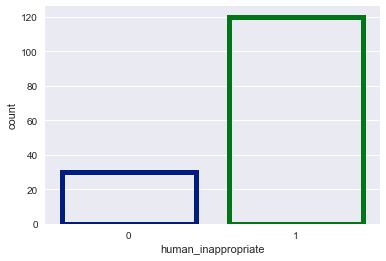

In [25]:
ax = sns.countplot(x="human_inappropriate", data=df,
                   facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 2))

## Length of Comments

The Content Moderator cognitive service requires that text comments passed into the API have a length of between 1 and 1024 characters (inclusive). Put differently, any empty (i.e., length 0) text comment passed into the API or any comment whose length exceeds 1024 characters will cause the API to return an error. As such, we will need to check whether all of the comments in our dataset are of an appropriate length for the API.

#### Task 03:

Write some code that will display the minimum length and maximum length of the text comments in the dataframe

#### Question 03:

What is maximum length of the text comments in the dataframe?

In [108]:
tamano = df.comment_text.str.len()


#display the minimum length of the of the items in the "comment_text" column
print('Minimun', min(tamano))

#print the maximum length of the of the items in the "comment_text" column
print('Maximun', max(tamano))

print (df['comment_text'].str.len().min())
print (df['comment_text'].str.len().max())

Minimun 20
Maximun 924
20
924


## Connect to the Azure Content Moderator Cognitive Service

Now that we're familiar with our dataset, let's connect to the Content Moderator cognitive service. As noted at the beginning of the lab, you will need your API key and endpoint URL in order to connect to the Content Moderator API, so please be sure that you followed the earlier instructions in this assignment, and added your key and endpoint values to the appropriate variables. 

When you're certain that you've stored your key and endpoint values in the `api_key` and `endpoint` variables, run the code cell below to authenticate yourself with the Azure Content Moderator service, and create a new instance of a Content Moderator client. Your `client` object will be needed to use all of the functions available through the  Content Moderator service.



In [27]:
#authenticate with the Content Moderator service, and create a Content Moderator client object
client = ContentModeratorClient(endpoint=endpoint, credentials=CognitiveServicesCredentials(api_key))

## The `get_inappropriate_terms()` Function

Working with the Content Moderator API is a bit tricky. For example, the current version of the API only accepts file objects as input (as opposed to, say, a simple string variable). Microsoft's engineers have promised that they will improve this in the next release, but for now we'll just need to work around this issue. The results that are returned by the API are also quite complex. For example, they include an automatically corrected version of the input text, extensive details about any personally identifiable information (PII) that the API detected, the location of each inappropriate term in the input text, etc.

In light of the above considerations, and given that this is our first time working with a Cognitive Services API, I have created a `get_inappropriate_terms()` function for this assignment that should make working with the API much easier. In brief, we will simply need to pass in a comment (as a string variable) to the function. It will then call the API, and return any inappropriate terms as a list.

Run the code cell below to add the `get_inappropriate_terms()` function to your lab assignment program.

In [28]:
#define a function that will pass a comment to the API, and return any inappropriate 
#terms that the API identifies
def get_inappropriate_terms(comment):
  #write comment to local file -- this is unfortunately necessary because the API
  #currently only accepts file-based input.  :(
  with open('comment.txt', 'w') as f:
    f.write(comment)
  
  #send comment to Content Moderator API, and get the results
  with open('comment.txt', 'rb') as f:
    results = client.text_moderation.screen_text(text_content_type='text/plain', text_content=f, language='eng', autocorrect=True, pii=True)

  #define a list to hold any inappropriate terms that the API has identified
  inappropriate_terms = []

  #if at least one inappropriate term was identified
  if results.terms is not None:
    #populate the inappropriate_terms list with terms identified by the API
    inappropriate_terms = [dt.term for dt in results.terms]

  #sleep for 1 second (in deference to the API's limit of one transaction per second)
  time.sleep(1)
  
  #return a list containing any inappropriate terms 
  return inappropriate_terms

## Test the Content Moderator API

Now that we've connected to the Content Moderator cognitive service, let's test the API.

#### Task 04:

The code cell below contains a quote from *Henry IV, Part I* by William Shakespeare. Write some code that will pass this quote to the `get_inappropriate_terms()` function, and print the list of inappropriate terms that the API identifies.

#### Question 04:

Which words in the quote from William Shakespeare were identified as inappropriate by the Content Moderator API?

In [29]:
#define a quote from Shakespeare's Henry IV, Part I
shakespeare_quote = 'Thou clay-brained guts, thou knotty-pated fool, thou whoreson obscene greasy tallow-catch!'

#pass the Shakespeare quote to the get_inappropriate_terms() function, and print the results
get_inappropriate_terms(shakespeare_quote)


['whoreson']

## Process Comments

If you've reached this point in the lab, then you've already been able to set up a cognitive service on the Microsoft Azure platform and successfully communicate with the service's API using Python. Congratulations!

Our next task will be to process all of the comments in our dataset. This will involve the following steps for each comment:

1. Send a comment to the API, and get the resulting list of inapproprite terms for that comment.
2. Determine how many inappropriate terms were identified by the API for the comment, and record the number of inappropriate terms in a list.

Once these steps have been completed for each comment, we will add a new column to our dataframe that indicates whether the API found each comment to be appropriate or not. Run the code cell below to perform these tasks.

**Note:** Recalling that we are limited to one API transaction per second, it will take approximately 2.5 to 3 minutes to process all of the comments in our dataset. As such, please be patient!

In [32]:
#define a list to hold the number of inappropriate terms in each comment
inappropriate_term_counts = []

#process each comment in the dataframe
current_comment = 0
number_of_comments = len(df['comment_text'])
for comment in df['comment_text']:
  #display overall progress
  clear_output(wait=True)
  current_comment += 1
  print('Processing comment {0} of {1}...'.format(current_comment, number_of_comments))
  #get a list of inappropriate terms for the current comment
  results = get_inappropriate_terms(comment)
  #add the number of inappropriate terms for this comment to the list
  inappropriate_term_counts.append(len(results))  

#add a column to the dataframe indicating whether the API found each comment to be appropriate or not
df['api_inappropriate'] = [1 if n > 0 else 0 for n in inappropriate_term_counts]

#update status
clear_output(wait=True)
print("Processing complete!")

Processing complete!


## Appropriate or Inappropriate?

Earlier in this lab, we determined the number of comments in the dataset that were found to be appropriate by human judges. Now let's see how many of the comments the Content Moderator API found to be appropriate. Remember that we just added a new column named `api_inappropriate` to our dataframe, and that the values in this column indicate whether the API found each comment to be appropriate or not (inappropriate = 1, appropriate = 0).

#### Task 05:

Write a line of code in the cell below that will display the number of comments in the dataset that the Content Moderator API found to be appropriate.

#### Question 05:

How many comments in the dataset did the Content Moderator API find to be appropriate?

In [82]:
#display the number of comments in the dataset that the Content Moderator API found to be appropriate
#sum(df.api_inappropriate == 0)

pd.crosstab(df.human_inappropriate, df.api_inappropriate)

api_inappropriate,0,1
human_inappropriate,,
0,29,1
1,91,29


Another important consideration is the extent to which the conclusions of the human judges and the Content Moderator service overlap.

#### Task 06:

Write a line of code in the cell below that will display the number of comments in the dataset that both the human judges and the Content Moderator API considered to be appropriate. 
* **Hint #1:** The answer will be the number of comments where the value of `human_inappropriate` is 0, and the value of `api_inappropriate` is 0.
* **Hint #2:** A quick and easy way to answer questions like this is to generate a cross-tabulation table for the two variables of interest. See [this article](https://pbpython.com/pandas-crosstab.html) for some examples.

####Question 06:

How many comments in the dataset were considered to be appropriate by both the human judges and the Content Moderator API?

In [35]:
df.head(10)

,comment_text,toxic,obscene,threat,insult,identity_hate,human_inappropriate,api_inappropriate
0,holocaust was needed by the whole humanity,0,0,0,0,1,1,0
1,"You translated much more clumsy, dude.\nI just...",0,0,0,1,0,1,0
2,"Dont really like the liberals either, Too much...",0,0,0,1,0,1,0
3,WHO CARES WIKIPEDIA IS NOT A PLACE FOR INDIVID...,1,0,0,0,0,1,0
4,Wow dude. As your physician I suggest you sli...,0,0,1,0,0,1,0
5,The status quo version is plenty good enough f...,0,0,0,0,0,0,0
6,"Thank you, should I one day wish to yet again ...",0,1,0,0,0,1,1
7,Regarding your passing \n\nBecause you willful...,0,0,1,0,0,1,0
8,diablada = bolivia \n\nlook at maps. this show...,0,0,0,0,0,0,0
9,I'ma smack ya upside da head wit a shovel. \n\...,0,0,1,0,0,1,0


In [86]:
#display the number of comments in the dataset that both the human judges and the Content Moderator API considered to be appropriate
api = sum(df.api_inappropriate == 1)
human = sum(df.human_inappropriate == 1)
print('total Considered inappropriate:', api + human)

total Considered inappropriate: 150


Based on the previous two tasks, it should be clear that the human judges considered many more of the comments in the dataset to be inappropriate than the Content Moderator API. Let's explore this situation in a bit more detail.

The code cell below contains a function named `proportion_of_inappropriate_comments_identified()` that computes and returns the proportion of comments of the specified type (*toxic*, *obscene*, *threat*, etc.) that were labeled by human judges as inappropriate, *and also identified by the Content Moderator API as inappropriate*. Put differently, this function will tell us the proportion of inappropriate comments of a particular type that the API was able to correctly identify as inappropriate.

Run the code cell below to make this function available to your Python program.

In [72]:
#Define a function that computes the proportion of inappropriate comments of a particular type 
#that the API was able to correctly identify as inappropriate.
def proportion_of_inappropriate_comments_identified(comment_type):
  col1_vals = df[comment_type].tolist()
  col2_vals = df['api_inappropriate'].tolist()
  number_of_comments = len(col1_vals)
  number_of_inappropriate_comments = np.sum(col1_vals)
  identified = 0
  for i in range(number_of_comments):
    if (col1_vals[i] == 1 and col2_vals[i] == 1):
      identified += 1
  return identified / number_of_inappropriate_comments

#### Task 07:

The code cell below defines a list that contains the names of all of the various types of inappropriate comments in our dataset. Write a `for` loop that will iterate through the items in the list, pass the name of each comment type to the `percent_of_inappropriate_comments_identified()` function, and then display the results.

#### Question 07:

What proportion of the `threat` comments in the dataset was the API able to identify correctly? Report your answer using three decimals of precision (e.g., 0.135).

#### Question 08:
In general, what can you conclude about the Content Moderator API's ability to accurately identify inappropriate comments of various types?

In [1]:
#define a list of column names
comment_types = ['toxic', 'obscene', 'threat', 'insult', 'identity_hate']

#A 'for' loop that passes the name of each comment type to the percent_of_inappropriate_comments_identified() 
#function, and then display the results.
for comment_type in comment_types:
    x = proportion_of_inappropriate_comments_identified(comment_type)
    
    print(commment_type,x)

In [109]:
#define a list of column names
comment_types = ['toxic', 'obscene', 'threat', 'insult', 'identity_hate']
#A 'for' loop that passes the name of each comment type to the percent_of_inappropriate_comments_identified() 
#function, and then display the results.

for comment_type in comment_types:
   x = proportion_of_inappropriate_comments_identified(comment_type)
   print (comment_type, x)

toxic 0.17391304347826086
obscene 0.6666666666666666
threat 0.0
insult 0.16
identity_hate 0.19230769230769232
